# Introduction to bayesian hyperparameter optimization 


## Introduction

In machine learning, a hyperparameter is any parameter that influe on the model's capacity or the learning algorithm, and that is not learned by the algorithm istelf. Finding the right set of hyperparameters is a crucial issue since the model's performance will highly depend on it. As an example, some of the recent developpements in image processing has been more powered by the right parametrization of the algorithms than by the emergence of new techniques.

Some examples of hyperparameters are:
* The number of trees in a random forest
* The learning rate of a gradient descent based optimization algorithm
* Even whether applying PCA or not to the input of an algorithm can be an hyperparameter 

In most case, data scientists choose to tune the hyperparameters manualy, based on trial and error and their own experience, or using a grid search algorithm. However when the number of hyperparameter starts to increase dramatically (such as in deep learning), this method can be really time consuming and poorly efficient. Therefore, researchers started exploring methods to achieve automate hyperparameter tuning.

In this notebook, I will introduce the methods described in [Algorithms for Hyper-Parameter Optimization](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) and available through the package [hyperopt](https://hyperopt.github.io/hyperopt/). I will quickly introduce the theoretical background behind bayesian optimization, but if you want to have a more in depth explanation I would recommend you read the original paper, or [this very good article](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) for a more accessible description.

The goal of its introduction is to get familiar with the algorithm and the package in order to use it to optimize hyperparameters of deep learning algorithms. If you are already familiar with that topic, you can jump to the deep learning examples.

## 1) Bayesian optimization

Bayesian optimization seeks to minimize a function *f* over its domain *X*:

\begin{equation*}
x^* = argmin_{x\in X}(f(x))
\end{equation*}

As an example, *X* can be the space of the hyperparameters and *f* a score of the machine learning algorithm. One of the great advantages of bayesian optimization is that it can be still efficient on non convex, stochastic or even non continuous functions. 

The general idea behind bayesian hyperparameter optimization is that we can use the historical measurements of the loss *f(x)* to choose the point *x* to evaluate next that is the most likely to decrease *f*. 

If we put it more formally, bayesian optimisation builds a probabilistic model *M* based on passed observations *(x,f(x))* as a surrogate for the function f. It chooses the next evaluation point in order to maximize an aquisition function. It then updates *M* thanks to this new observation and repeats the process.

So there is two main elements in this algorithm : the probabilistic model and the acquisition function.

In the case of hyperparameter optimization, the most used acquisition function is **the expected improvement (EI)**:

\begin{equation*}
EI(x|D) =  \int_{-\infty}^{\infty} max(t-f,0)\cdot p(f|x)\,df
\end{equation*}

The EI measures how *f(x)* is likely to be less than a given threshold t , which can be as an example the minimal value *fmin* reached so far. Here *D* represents the available data and  *p(f|x)* is **the probabilistic model for f(x)**. 

There exist several models for estimating p(f|x) that have been proven efficient. The most common are:

* Gaussian processes 
* Tree Parzen Estimators (TPE) 
* Random Forests 

These estimators are briefly described and compared in [Towards an Empirical Foundation for Assessing Bayesian Optimization of Hyperparameters](https://www.cs.ubc.ca/~hoos/Publ/EggEtAl13.pdf)

In this notebook, we will use the Tree Parzen Estimator which is implemented in the hyperopt package. The principle of the tree parzen estimator is not to model *p(f|x)* but rather to model *p(x|f)* using two different distributions:

\begin{equation*}
p(x|f) = \left\{ \begin{array}\ l(x)& if & f(x)\leq y^* \\
g(x)&if&f(x)>y^*
\end{array}\right.
\end{equation*}

Where y** * is a threshold greater than the minimun reached value so far fmin . Typically,  y* is set to be a quantile of the observed values so that:

\begin{equation*} p(y < y^∗) = \gamma \end{equation*}.

Using byes formula and injecting *p(x|f)* in the expression of the expected improvement, one finds that the TPE defines to expected improvement at **x to be equivalent to :

\begin{equation*}
\frac{1}{ \gamma + \frac{g(x)}{l(x)} * (1-\gamma )}
\end{equation*}

Hence, the TPE estimator samples points with high probability under *l(x)* and low probability under *g(x)*. Put in other words, it tries to find the points *x* that are jointly likely to be in a region of low *f(x)* values and not likely to be in a region of high *f(x)* values.


## 2) Random search

Random search is another method that have been explored in [ref] and compared with bayesian optimization. Random search consists in randomly sampling the hyperparameter space, and therefore is faster than bayesian optimization since it doesn't need either to build a surrogate function or to approximate an aquisition function.

Despite its random aspect, this method gives better results than the grid search, and is less expensive. 


## 3) Basic Example

Let's apply randoms search and bayesian optimization to simple functions. We will use:
* A gaussian mixture based function
* A piecewise linear function

The goal is to minimize these two functions. These functions could be the loss of a machine learning algorithm, depending on only one hyperparameter.

In [1]:
#general
import numpy as np
from scipy.stats import norm
import time
import pandas as pd

#Bayesian optimisation
from hyperopt import fmin, tpe, hp, rand, STATUS_OK, Trials

#Visualisation
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.patches as patches
import matplotlib.path as path
from IPython.display import HTML
from IPython.lib.display import YouTubeVideo

import warnings
warnings.filterwarnings("ignore")

C:\Users\Alexis\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Let's plot the objective functions:

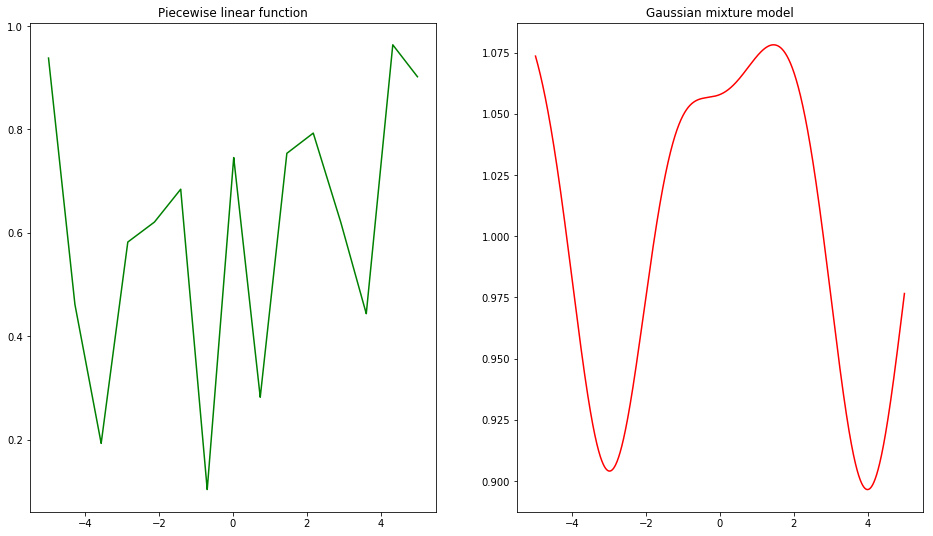

In [2]:
#gaussian mixture
f, g, h = norm(loc=-3, scale = 1), norm(loc=0, scale = 1), norm(loc=4, scale = 1)
def gaussian_mixture(x):
    return(0.49*(1-f.pdf(x))+0.1*(1-g.pdf(x))+0.51*(1-h.pdf(x)))

# =============================================================================
# Random piecewise linear function
# =============================================================================
class piecewise:
    
    def __init__(self,domain=(-5,5),breaks=20,values=(0,1),seed=37):
        np.random.seed(seed)
        self.steps = np.linspace(domain[0]-0.01,domain[1]+0.05,breaks)
        self.values = np.random.uniform(values[0],values[1],breaks)
    
    def __call_one(self,x):
        idx=np.where(self.steps < x)[0][-1]
        return(self.__step(x,self.values[idx],self.values[idx+1],self.steps[idx],self.steps[idx+1]))
     
    def __step(self,x,y0,y1,x0,x1):
        a = (y1-y0)/(x1-x0)
        b = y0-a*x0
        return(a*x+b)
        
    def __call__(self,x):
        try:
            return([self.__call_one(y) for y in x])
        except TypeError:
            return(self.__call_one(x))
        

#random piecewise linear function
def piecewise_linear(x):
    return(piecewise(breaks=15)(x))

#plot the functions to minimize
x=np.linspace(-5,5,50000)

fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(121)
ax.plot(x, piecewise_linear(x),color='g')
ax.set_title('Piecewise linear function')
ax = fig.add_subplot(122)
ax.plot(x, gaussian_mixture(x),color='r')
ax.set_title('Gaussian mixture model')
plt.show()

### 3.1) Optimizing with hyperopt

As stated before, we will use the hyperopt package to find the minimum of these functions.

The central element of hyperopt is the *fmin* functions, which performs the bayesian optimization. Some of its arguments are:

* objective: an objective function, which takes in a point of the space and returns a dictionary with the information you wish to track. This dictionnary has two mandatory keys : 
    * 'loss': the evaluation of the function we want to minimize
    * 'status': a key that flags if the function has been evaluated correctly. This is useful is the function is not defined on a subset of the search space. The keys are defined in hyperopt.STATUS_STRING.
* space: the search space
* algo: one of tpe.suggest (bayesian optimization) or rand.suggest (random search)
* max_evals: the number of evaluations 
* trials: trials is a Trial object defined for the optimization task that stores the history of the process

Now we can run both algorithms on our two test functions:

In [3]:
#Gaussian mixture
def objective1(x):
    return {
        'loss': gaussian_mixture(x),
        'x':x,
        'status': STATUS_OK,
        'eval_time': time.time()
        }

#Piecewise linear
def objective2(x):
    return {
        'loss': piecewise_linear(x),
        'x':x,
        'status': STATUS_OK,
        'eval_time': time.time()
        }


start = time.time()

#Gaussian mixture function optimization with tpe algorithm
trials_tpe_1 = Trials()

best_tpe_1 = fmin(objective1,
    space=hp.uniform('x', -5, 5),
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials_tpe_1)


#Gaussian mixture function optimization with random search
trials_rnd_1 = Trials()

best_rnd_1 = fmin(objective1,
    space=hp.uniform('x', -5, 5),
    algo=rand.suggest,
    max_evals=1000,
    trials=trials_rnd_1)


#Piecewise linear function optimization with tpe algorithm
trials_tpe_2 = Trials()

best_tpe_2 = fmin(objective2,
    space=hp.uniform('x', -5, 5),
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials_tpe_2)

#Piecewise linear function optimization with random search
trials_rnd_2 = Trials()

best_rnd_2 = fmin(objective2,
    space=hp.uniform('x', -5, 5),
    algo=rand.suggest,
    max_evals=1000,
    trials=trials_rnd_2)

print('Time taken : {:.2f}s'.format(time.time() - start))

Time taken : 11.86s


### 3.2) Comparing TPE and Random search

We can retrieve some information about the processes thanks to the Trials objects:

In [4]:
result = pd.DataFrame(index=['GM + TPE', 'GM + Random search','PL + TPE','PL + Random search'],columns=['trial'])
result['trial'][0]=trials_tpe_1
result['trial'][1]=trials_rnd_1
result['trial'][2]=trials_tpe_2
result['trial'][3]=trials_rnd_2

result['best loss']=result['trial'].apply(lambda x: x.best_trial['result']['loss'])
result['best x']=result['trial'].apply(lambda x: x.best_trial['result']['x'])
result['time taken (s)']=result['trial'].apply(lambda x: round(x.results[-1]['eval_time']-x.results[0]['eval_time'],2))
#trial id corresponds to the trial number when executed sequentially
result['best iteration']=result['trial'].apply(lambda x: x.best_trial['tid'])
result['time to best iteration']=result['trial'].apply(lambda x: round(x.best_trial['result']['eval_time']-x.results[0]['eval_time'],2))

result['real min loss']=gaussian_mixture(np.linspace(-5,5,50000)).min()
result['real min loss'][2:4]=min(piecewise_linear(np.linspace(-5,5,50000)))
result['real best x']=np.linspace(-5,5,50000)[gaussian_mixture(np.linspace(-5,5,50000)).argmin()]
result['real best x'][2:4]=np.linspace(-5,5,50000)[np.argmin(piecewise_linear(np.linspace(-5,5,50000)))]

result=result.drop('trial',axis=1)
result.head(4)

,best loss,best x,time taken (s),best iteration,time to best iteration,real min loss,real best x
GM + TPE,0.896526,3.997950,5.48,816,3.69,0.896526,3.999780
GM + Random search,0.896531,4.006948,1.31,368,0.46,0.896526,3.999780
PL + TPE,0.103962,-0.697985,5.94,475,1.49,0.103489,-0.698514
PL + Random search,0.104742,-0.700185,2.01,702,1.24,0.103489,-0.698514


The functions are quite simple, so this is no surprise that both algorithms comes very close to the real minima. 

It is also not a surprise that random search is more than 4 times faster. However this aspect becomes neglictible as the time of evaluation of the objective function increases, as in deep learning.

TPE seems however to perform little better than random search on the piecewise linear function. Let's see if this result holds statistically:

In [5]:
def get_best_loss(function,algorithm):
    def obj(x):
        return {
            'loss': function(x),
            'x':x,
            'status': STATUS_OK,
            'eval_time': time.time()
            }
    t=Trials()
    best = fmin(obj,
        space=hp.uniform('x', -5, 5),
        algo=algorithm,
        max_evals=1000,
        trials=t)
    return(t.best_trial['result']['loss'])

tpe_=[]
rnd_=[]
start=time.time()
n=100
for i in range(n):
    tpe_.append(get_best_loss(piecewise_linear,tpe.suggest))
    rnd_.append(get_best_loss(piecewise_linear,rand.suggest))
print('Time taken: {:.2f}min'.format((time.time()-start)/60))

Time taken: 9.63min


Let's estimate a confidence interval for the TPE losses to be lower than the random searhe's ones:

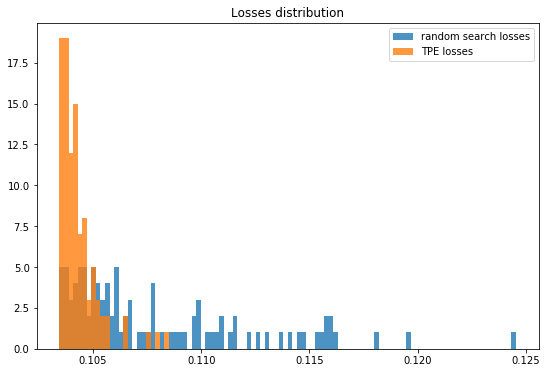

Best loss 99.9% confidence interval of TPE algorithm: [0.1043094 , 0.1043099]
Best loss 99.9% confidence interval of Random search algorithm: [0.1078872 , 0.1078999]


In [6]:
s_tpe=n/(n-1)*np.var(tpe_)
s_rnd=n/(n-1)*np.var(rnd_)

avg_tpe=np.mean(tpe_)
avg_rnd=np.mean(rnd_)

conf_tpe=(avg_tpe-3.390*s_tpe/np.sqrt(n),avg_tpe+3.390*s_tpe/np.sqrt(n))
conf_rnd=(avg_rnd-3.390*s_rnd/np.sqrt(n),avg_rnd+3.390*s_rnd/np.sqrt(n))

plt.figure(figsize=(9,6))
xrange=min([min(rnd_),min(tpe_)]),max([max(rnd_),max(tpe_)])
plt.hist(rnd_,bins=100,range=xrange,label='random search losses',alpha=0.8)
plt.hist(tpe_,bins=100,range=xrange,label='TPE losses',alpha=0.8)
plt.legend()
plt.title('Losses distribution')
plt.show()

print('Best loss 99.9% confidence interval of TPE algorithm: [{:.7f} , {:.7f}]'.format(*conf_tpe))
print('Best loss 99.9% confidence interval of Random search algorithm: [{:.7f} , {:.7f}]'.format(*conf_rnd))


The difference, though very small, **is statisticaly significant**. This result can be explained by analysing the sampling process. Indeed:
* Random search algorithm has the same probability of sampling any point in the space, hence the probability to be close to the true minimum is proportional to the surface of the curve that is close to the true minimum
* Bayesian search tends to draw more samples in the promising areas, hence it explores more in details the regions of the curve likely to be minimas. However this happens at the expence of the exploratory power of this method, which is more likely to be stuck at a local minima of the curve

In the case of the piecewise linear function, the region of the minima is very narrow which can explain why the TPE performs better.

### 3.3) Plotting the process

The following animations allows to visualize the sampling process along the optimization phasis. If you are interested in the code used to create those, it is in [utils.py](https://github.com/AlxClt/Hyperparameters/blob/master/utils.py) (animation_plot function):

#### a) Sampling strategy of the random search algorithm on the piecewise linear loss:

We can observe that the x values are randomly drawn (video will open in a new tab):

[![Watch the video](img/random_seach_vid.JPG)](https://www.youtube.com/watch?v=yZ1vRARE65A)


#### b) Sampling strategy of the TPE algorithm on the piecewise linear loss:

We can see that the algotithm tends to intensify the sampling in the most promising region

[![Watch the video](img/tpe_vid.JPG)](https://www.youtube.com/watch?v=eAV0HK5hKQ0)

## 4) An example on traditional machine learning

We will use a logistic classifier trained by gradient descent to classify [the digits dataset](https://scikit-learn.org/stable/datasets/index.html#digits-dataset). This dataset contains 5620 images of size 8x8 reresenting handwritten digits from 0 to 9.

We will search the following parameters:

* **apply_pca**: applying pca to the input or not
* **pca_n_components**: if we apply PCA, how many components do we keep?
* **alpha**: multiplier of the regularization term in the SGD Classifier
* **l1_ratio**: ratio between l1 and l2 penalties. By including 0 and 1 in its search domain we include whether we use l2 penalty (l1_ratio=0), l1 penalty (l1_ratio=1) or elastic net penalty (all other possibilities)

The model will be trained by 5 fold cross validation.

We will compare the time of execution and the best accuracy for :
* TPE optimized algorithm
* Random search optimized algorithm
* Grid search optimized algorithm

In [6]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

We have to wrap the model in a function returning a loss that we will minimize. We choose this loss to be one minus the cross validation accuracy, so that minimizing it leads to maximize the corss validation score:

In [12]:
def apply_logistic(hparams):
     
    apply_pca = hparams.pop('apply_pca')

    if(apply_pca):
        pca_n_components = int(hparams.pop('pca_n_components'))
        pca = PCA(n_components = pca_n_components)
        logistic = SGDClassifier(loss='log',max_iter=10000, tol=1e-5, random_state=0, **hparams)
        pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
    else: 
        logistic = SGDClassifier(loss='log',max_iter=10000, tol=1e-5, random_state=0, **hparams)
        pipe = Pipeline(steps=[('logistic', logistic)])

    digits = datasets.load_digits()
    X_digits = digits.data
    y_digits = digits.target

    scores = cross_val_score(pipe, X_digits, y_digits, cv=5, scoring='accuracy')

    return(1-np.mean(scores))

def objective(hparams):
    return {
        'loss': apply_logistic(hparams),
        'x':hparams,
        'status': STATUS_OK,
        'eval_time': time.time()
        }

### 4.1) Defining the search space

Now we need to define a search space that is a bit more complicated than what we used so far. The space must be decribed by paris {key: choice} (that can be nested), where key is the name of the hyperparameter and choice the prior distibution from which we should draw the hyperparameter.

Hyperopt provides a limited set of priors:
* hp.choice: a discrete choice among a list
* hp.uniform: a uniform prior
* hp.normal: a noral prior
* hp.loguniform: a log uniform prior
* hp.lognormal: a log normal prior
* Quantilised versions of these priors (excet hp.choice) to modelise discrete distributions : hp.quniform, hp.qlognormal...
    
With these tools, we can define our search space. We will use uniform priors, which means that we are providing no prior information regarding the optimal hyperparameters, except their range.

Defining the search space is a key step. The choice of prior will strongly influence the search space and hence can make the algorithm converge faster or unable to find a good minima. With hyperopt, one must be carful of well defining the statisticaly dependance between parameters. Look at the following example:

In [8]:
bad_space = {'alpha':hp.uniform('alpha',0.0001,5),
            'l1_ratio': hp.uniform('l1_ratio',0.0001,1),
            'apply_pca':hp.choice('apply_pca',[0,1]),
            'pca_n_components':hp.quniform('pca_n_components',1,64,2)}

space = hp.choice('with_pca',
    [
        {'apply_pca':0,'alpha':hp.uniform('alpha_0',0.0001,5),'l1_ratio': hp.uniform('l1_ratio_0',0,1)},
        {'apply_pca':1,'pca_n_components':hp.quniform('pca_n_components',1,64,2),'alpha':hp.uniform('alpha_1',0.0001,5),'l1_ratio': hp.uniform('l1_ratio_1',0,1)}
    ])


In *bad_space*, both *alpha* and *l1_ratio* are defined **independantly** from *apply_pca*. This means that in this case, the algorithm will look for the values of *alpha* and *l1_ratio* that are a good tradeoff between the case where pca is applied and the case it is not.

In *good_space*, hyperopt makes a difference between the case where pca is applied and the one where it is not. Indeed, hyperopt sees there four different parameters *alpha_0*, *l1_ratio_0*, *alpha_1*, *l1_ratio_1*. It is then able to explore the most promising regions in both cases.

Note that in the case of random search, there is a difference between these two spaces only if we define a different prior in both cases.

In [20]:
space = hp.choice('with_pca',
    [
        {'apply_pca':0,'alpha':hp.uniform('alpha_0',0.0001,5),'l1_ratio': hp.uniform('l1_ratio_0',0,1)},
        {'apply_pca':1,'pca_n_components':hp.quniform('pca_n_components',1,64,2),'alpha':hp.uniform('alpha_1',0.0001,5),'l1_ratio': hp.uniform('l1_ratio_1',0,1)}
    ])


#example of space:
import hyperopt.pyll.stochastic
print(hyperopt.pyll.stochastic.sample(space))

{'alpha': 1.476172333624065, 'apply_pca': 0, 'l1_ratio': 0.5508033105652047}


### 4.2) Random search

In [21]:
space = hp.choice('with_pca',
    [
        {'apply_pca':0,'alpha':hp.uniform('alpha_0',0.0001,5),'l1_ratio': hp.uniform('l1_ratio_0',0,1)},
        {'apply_pca':1,'pca_n_components':hp.quniform('pca_n_components',1,64,2),'alpha':hp.uniform('alpha_1',0.0001,5),'l1_ratio': hp.uniform('l1_ratio_1',0,1)}
    ])


trials_rnd=Trials()

start=time.time()
best = fmin(objective,
   space=space,
   algo=rand.suggest,
   max_evals=500,
   trials=trials_rnd)

In [22]:
print('Time taken by Random search: {:.2f}min'.format((time.time()-start)/60))
print('Best Random search accuracy : {:.2f}%'.format(100*(1-trials_rnd.best_trial['result']['loss'])))
print('Best Random search hparams : \n')
print(best)

Time taken by Random search: 11.66min
Best Random search accuracy : 93.03%
Best Random search hparams : 

{'alpha_0': 0.3728772927973065, 'l1_ratio_0': 0.2143373518398285, 'with_pca': 0}


### 4.3) TPE

In [23]:
space = hp.choice('with_pca',
    [
        {'apply_pca':0,'alpha':hp.uniform('alpha_0',0.0001,5),'l1_ratio': hp.uniform('l1_ratio_0',0,1)},
        {'apply_pca':1,'pca_n_components':hp.quniform('pca_n_components',1,64,2),'alpha':hp.uniform('alpha_1',0.0001,5),'l1_ratio': hp.uniform('l1_ratio_1',0,1)}
    ])


trials_tpe=Trials()

start=time.time()
best = fmin(objective,
   space=space,
   algo=tpe.suggest,
   max_evals=500,
   trials=trials_tpe)


In [24]:
print('Time taken by TPE: {:.2f}min'.format((time.time()-start)/60))
print('Best TPE accuracy : {:.2f}%'.format(100*(1-trials_tpe.best_trial['result']['loss'])))
print('Best TPE hparams : \n')
print(best)

Time taken by TPE: 5.26min
Best TPE accuracy : 93.48%
Best TPE hparams : 

{'alpha_0': 0.3117484759238743, 'l1_ratio_0': 0.3179302416097942, 'with_pca': 0}


### 4.4) Grid search

We need to wrap the function differently for that:

In [39]:
start=time.time()

#1. with pca
param_grid = {
    'pca__n_components':[5,10,20,30,40,50,64], #reasonable assumption
    'logistic__alpha': np.logspace(-4, 1, 20), #discrete with 20 values 
    'logistic__l1_ratio': np.linspace(0,1,20)  #discrete with 20 values 
}

logistic = SGDClassifier(loss='log',max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

search = GridSearchCV(pipe, param_grid, iid=False, cv=5,
                      return_train_score=False)
search.fit(X_digits, y_digits)

best_score = search.best_score_
best_params = search.best_params_

#2. without pca
param_grid = {
    'logistic__alpha': np.logspace(-4, 1, 20), #discrete with 20 values instead of continuous
    'logistic__l1_ratio': np.linspace(0,1,20)  #discrete with 20 values instead of continuous
}

logistic = SGDClassifier(loss='log', max_iter=10000, tol=1e-5, random_state=0)
pipe = Pipeline(steps=[('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

search = GridSearchCV(pipe, param_grid, iid=False, cv=5,
                      return_train_score=False)
search.fit(X_digits, y_digits)

if(search.best_score_>best_score):
    best_params=search.best_params_
    best_score=search.best_score_

In [40]:
print('Time taken by grid search: {:.2f}min'.format((time.time()-start)/60))
print('Best grid search score : {:.2f}'.format(100*best_score))
print('Best grid search hparams : \n')
print(best_params)

Time taken by grid search: 46.89min
Best grid search score : 92.87
Best grid search hparams : 

{'logistic__alpha': 0.07847599703514607, 'logistic__l1_ratio': 0.0}


We can observe that the best score is also obtained without applying pca to the input.

### 4.5) Results and comparison of the methods

Note that the above results can vary a bit if you reexecute the notebook.

Globally, random search and TPE performs better than grid search both in terms of time and accuracy. TPE is slightly better in accuracy than random search, but surpisingly also in time.

**The TPE algoritm made us gain 'just' a bit in accuracy but a lot in time.** Hence, it is worth taking the time to learn about hyperopt as it might make you gain time.

We can observe the sampling strategy of Random search and TPE.

In [27]:
def get_values(trial,*keys):
        
    res={}
    
    for key in keys:
        res[key]=[]
        
    for t in trial:
        vals=t['misc']['vals']
        
        for key in keys:
            if key=='score':
                res['score'].append(1-t['result']['loss'])
            else:
                if len(vals[key])>0:
                     res[key].append(vals[key][0])
                else:
                     res[key].append(np.nan)
    return(res)

vals_tpe=get_values(trials_tpe,'alpha_0','l1_ratio_0','with_pca','alpha_1','l1_ratio_1','pca_n_components','score')
vals_rnd=get_values(trials_rnd,'alpha_0','l1_ratio_0','with_pca','alpha_1','l1_ratio_1','pca_n_components','score')

In the case of random search, it corresponds to the priors we have chosen while defining the search space: 

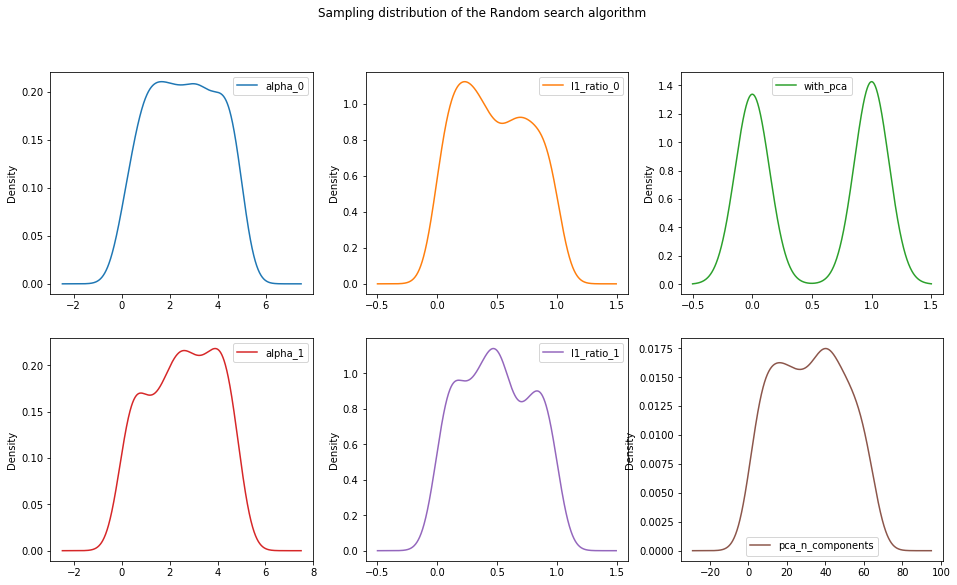

In [34]:
vals_rnd=pd.DataFrame(vals_rnd)
vals_rnd.iloc[:,0:6].plot(kind='kde',subplots=True, sharex=False, layout=(2,3),title='Sampling distribution of the Random search algorithm',figsize=(16,9))
plt.show()

However for TPE, it is an approximation of the posterior distribution estimated by the algorithm. This can be interesting to estimate the influence of each parameter on the algorithm:

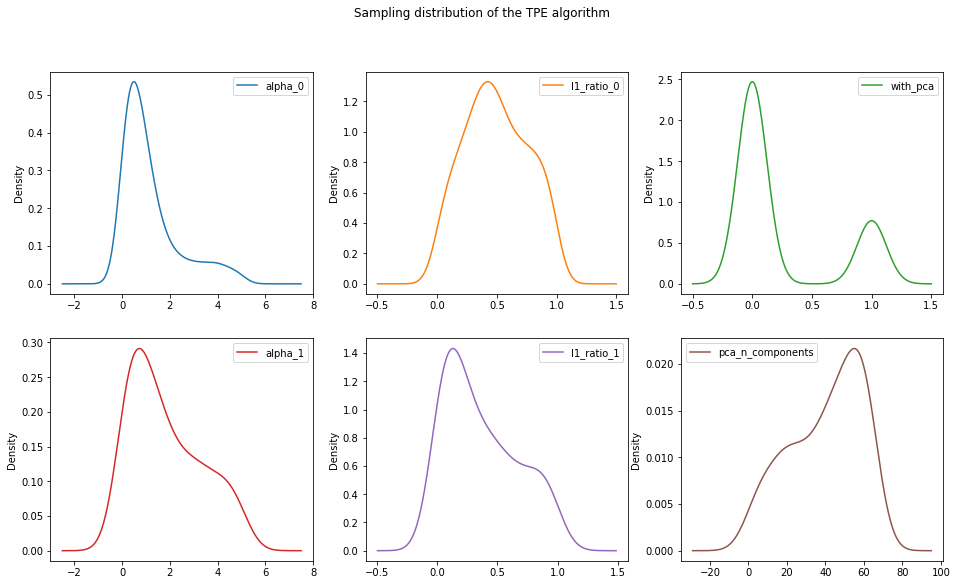

In [33]:
vals_tpe=pd.DataFrame(vals_tpe)
vals_tpe.iloc[:,0:6].plot(kind='kde',subplots=True, sharex=False, layout=(2,3),title='Sampling distribution of the TPE algorithm',figsize=(16,9))
plt.show()

It is interesting to notice that the distribution of *alpha* and *l1_ratio* changes given if we apply pca or not.

# Conclusion

Bayesian hyperparameter optimization is an interesting method to find a right set of hyperparameters. Though there is no real theoretical guarantees, it has been empirically shown that this method can beat human knowledge at optimizing algorithms.

One of the main limits of TPE algorithm is that it is bad at estimating joint distributions. It is however very likely that the optimal values of hyperparameters depend on each other, this limits the algorithm.
